## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [1]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [2]:
# Download MNIST
transform = transforms.Compose([
    # see what different tranformation you can do , one is converting the image into tensor
    transforms.ToTensor(),
    # The values (0.1307,) and (0.3081,) are the global mean and std of the MNIST dataset.
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
   # fill this
   root='./data',       # Directory to save/load the data
    train=True,          # True = Training set (60,000 images)
    download=True,       # Downloads the data if it doesn't exist in 'root'
    transform=transform  # Applies the transform defined above
)
test_dataset = torchvision.datasets.MNIST(
    # fill this
    root='./data',
    train=False,         # False = Test set (10,000 images)
    download=True,
    transform=transform
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 530kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.35MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.58MB/s]


✅ MNIST loaded: 60000 train, 10000 test images


In [3]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    #fill this
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
    """
    Create train, support, and query sets for a specific task.
    """
    train_data = []
    support_data = []
    query_data = []

    # Access targets directly if possible (faster), otherwise iterate
    # torchvision MNIST stores labels in .targets (Tensor) or .labels
    targets = dataset.targets if hasattr(dataset, 'targets') else [y for _, y in dataset]

    # Convert targets to numpy for easier indexing if it's a Tensor
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    else:
        targets = np.array(targets)

    for class_label in task_classes:
        # 1. Find indices of all examples belonging to this specific class
        class_indices = np.where(targets == class_label)[0]

        # 2. Shuffle indices to ensure random sampling (optional but recommended)
        np.random.shuffle(class_indices)

        # 3. Calculate split points
        # We need disjoint sets: Train -> Support -> Query
        stop_train = n_train
        stop_support = n_train + n_support
        stop_query = n_train + n_support + n_query

        # Check if we have enough data
        if len(class_indices) < stop_query:
            raise ValueError(f"Not enough data for class {class_label}. Needed {stop_query}, found {len(class_indices)}")

        # 4. Slice the indices
        idx_train = class_indices[:stop_train]
        idx_support = class_indices[stop_train:stop_support]
        idx_query = class_indices[stop_support:stop_query]

        # 5. Retrieve actual data and append to lists
        # We assume dataset[i] returns (image, label)
        for idx in idx_train:
            train_data.append(dataset[idx])

        for idx in idx_support:
            support_data.append(dataset[idx])

        for idx in idx_query:
            query_data.append(dataset[idx])

    return train_data, support_data, query_data
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [4]:
# Test the function

train_B, support_B, query_B = create_task_datasets(train_dataset, task_definitions['B'])
print(f"Task B - Train: {len(train_B)}, Support: {len(support_B)}, Query: {len(query_B)}")

Task B - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [5]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'
import torch.nn.functional as F

#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # 1. Convolutional Layer 1
        # Input: 1 channel (grayscale), Output: 6 channels, Kernel: 5x5
        # Image size changes: 28x28 -> 24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # 2. Convolutional Layer 2
        # Input: 6 channels, Output: 16 channels, Kernel: 5x5
        # Image size changes (after pool1): 12x12 -> 8x8
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Max Pooling Layer (2x2) - used twice
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Fully Connected Layers (Dense Layers)
        # Calculation for input features:
        # After conv1 (24x24) -> pool (12x12) -> conv2 (8x8) -> pool (4x4)
        # Final volume: 16 channels * 4 * 4 = 256
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes) # Final output

    def forward(self, x):
        # Layer 1: Conv -> ReLU -> Pool
        # x shape: [batch, 1, 28, 28] -> [batch, 6, 12, 12]
        x = self.pool(F.relu(self.conv1(x)))

        # Layer 2: Conv -> ReLU -> Pool
        # x shape: [batch, 6, 12, 12] -> [batch, 16, 4, 4]
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten: Convert 3D tensor to 1D vector for FC layers
        # x shape: [batch, 256]
        x = torch.flatten(x, 1)

        # Layer 3: FC -> ReLU
        x = F.relu(self.fc1(x))

        # Layer 4: FC -> ReLU
        x = F.relu(self.fc2(x))

        # Layer 5: Output Layer (No activation here, CrossEntropyLoss handles Softmax)
        x = self.fc3(x)
        return x

# Initialize the model
net = SimpleCNN(num_classes=10)
print(net)

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def remap_labels(labels, classes):
    """
    Maps original MNIST labels to 0, 1, 2... for the specific task.
    E.g. Task B [2, 3] -> 2 becomes 0, 3 becomes 1.
    """
    class_to_idx = {c: i for i, c in enumerate(classes)}
    new_labels = torch.tensor([class_to_idx[l.item()] for l in labels], device=device)
    return new_labels

def train_model(model, data, classes, epochs=5, lr=0.001):
    model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    loader = DataLoader(data, batch_size=10, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # CRITICAL: Remap labels to 0-(N-1) range
            targets = remap_labels(labels, classes)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    print(f"Training complete. Final Loss: {total_loss / len(loader):.4f}")
    return model

def modify_last_layer(model, num_classes):
    """Replaces the final fully connected layer for a new number of classes."""
    # Input features of the last layer (84 in LeNet implementation)
    in_features = model.fc3.in_features
    # Create new layer (weights are randomly initialized by default)
    model.fc3 = nn.Linear(in_features, num_classes)
    return model

In [7]:
#Method 1 - Fully Trained Binary Classifier on Task A
print("\n--- Method 1: Train from Scratch on Task A (Large Dataset) ---")

# 1. Get Data for Task A (0, 1)
task_a_classes = task_definitions['A'] # [0, 1]
train_A, _, _ = create_task_datasets(train_dataset, task_a_classes, n_train=500) # Using more data for "Large" training

# 2. Initialize fresh model for 2 classes
model_m1 = SimpleCNN(num_classes=2)

# 3. Train
model_m1 = train_model(model_m1, train_A, task_a_classes, epochs=5)


--- Method 1: Train from Scratch on Task A (Large Dataset) ---
Training complete. Final Loss: 0.0111


In [8]:
#Method 2 - Fine Tuning all 3 methods
print("\n--- Method 2: Random Init -> Fine-Tune A -> Fine-Tune B ---")

# 1. Initialize fresh model (Random Initialization)
model_m2 = SimpleCNN(num_classes=2)

# 2. Fine-tune on Task A Support Set (Small dataset: 5 shots)
# Note: This is "few-shot learning" territory
_, support_A, _ = create_task_datasets(train_dataset, task_definitions['A'], n_train=0, n_support=5)
print("Fine-tuning on Task A Support...")
model_m2 = train_model(model_m2, support_A, task_definitions['A'], epochs=10)

# 3. Fine-tune SAME model on Task B Support Set (Digits 2, 3)
_, support_B, _ = create_task_datasets(train_dataset, task_definitions['B'], n_train=0, n_support=5)
print("Transferring to Task B (Fine-tuning)...")

# We don't need to change layers because Task B also has 2 classes.
# However, the weights in the final layer will be adjusted to map 2->0 and 3->1
model_m2 = train_model(model_m2, support_B, task_definitions['B'], epochs=10)


--- Method 2: Random Init -> Fine-Tune A -> Fine-Tune B ---
Fine-tuning on Task A Support...
Training complete. Final Loss: 0.6932
Transferring to Task B (Fine-tuning)...
Training complete. Final Loss: 0.6922


In [9]:
print("\n--- Method 3: Pre-train All (0-9) -> Surgery -> Fine-Tune A ---")

# 1. Pre-train on ALL MNIST Data (10 classes)
# Use the full original train_dataset
model_m3 = SimpleCNN(num_classes=10)
print("Pre-training on full MNIST (this might take a moment)...")
# We just train on a subset here to keep it fast for demonstration,
# in real life use the whole set
subset_indices = list(range(1000))
subset_full_mnist = torch.utils.data.Subset(train_dataset, subset_indices)
model_m3 = train_model(model_m3, subset_full_mnist, classes=[0,1,2,3,4,5,6,7,8,9], epochs=3)

# 2. LAYER SURGERY
# The model currently outputs 10 scores. We need it to output 2.
print("Performing Layer Surgery...")
model_m3 = modify_last_layer(model_m3, num_classes=2)

# 3. Fine-tune on Task A Support Set
_, support_A, _ = create_task_datasets(train_dataset, task_definitions['A'], n_train=0, n_support=5)
print("Fine-tuning pre-trained model on Task A Support...")
model_m3 = train_model(model_m3, support_A, task_definitions['A'], epochs=10)


--- Method 3: Pre-train All (0-9) -> Surgery -> Fine-Tune A ---
Pre-training on full MNIST (this might take a moment)...
Training complete. Final Loss: 2.2121
Performing Layer Surgery...
Fine-tuning pre-trained model on Task A Support...
Training complete. Final Loss: 0.6128


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [10]:
#Analysis and Plots
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Updated train function to track loss
def train_model_with_history(model, data, classes, epochs=10, lr=0.001):
    model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    loader = DataLoader(data, batch_size=10, shuffle=True)
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in loader:
            inputs = inputs.to(device)
            targets = remap_labels(labels, classes)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Average loss for this epoch
        loss_history.append(epoch_loss / len(loader))

    return model, loss_history

def evaluate_model(model, query_data, classes, task_name):
    model.eval()
    y_true = []
    y_pred = []

    loader = DataLoader(query_data, batch_size=10, shuffle=False)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            targets = remap_labels(labels, classes) # Remap validation labels too!
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    return {
        "Method": task_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

In [11]:
results = []
histories = {}

# --- Method 1: Large Training on Task A (0 vs 1) ---
# Goal: Baseline high performance
print("Running Method 1...")
task_a = task_definitions['A']
train_A, _, query_A = create_task_datasets(train_dataset, task_a, n_train=500, n_query=100)

model_m1 = SimpleCNN(num_classes=2)
model_m1, hist_m1 = train_model_with_history(model_m1, train_A, task_a, epochs=10)
histories['Method 1 (Large Data)'] = hist_m1
results.append(evaluate_model(model_m1, query_A, task_a, "M1: Train Scratch (Task A)"))


# --- Method 2: Random Init -> Fine-Tune on Task B (2 vs 3) ---
# Goal: See how well a random model learns from very few examples (Support set)
print("Running Method 2...")
task_b = task_definitions['B']
_, support_B, query_B = create_task_datasets(train_dataset, task_b, n_train=0, n_support=5, n_query=100) # Only 5 examples!

model_m2 = SimpleCNN(num_classes=2)
model_m2, hist_m2 = train_model_with_history(model_m2, support_B, task_b, epochs=10)
histories['Method 2 (Random Init)'] = hist_m2
results.append(evaluate_model(model_m2, query_B, task_b, "M2: Random Init (Task B)"))


# --- Method 3: Pre-trained (0-9) -> Fine-Tune on Task A (0 vs 1) ---
# Goal: See benefit of transfer learning on small data
print("Running Method 3...")
# 1. Pre-train (Simulated)
model_m3 = SimpleCNN(num_classes=10)
subset_indices = list(range(1000))
subset_full_mnist = torch.utils.data.Subset(train_dataset, subset_indices)
# We don't plot pre-training history, just the fine-tuning part
model_m3, _ = train_model_with_history(model_m3, subset_full_mnist, list(range(10)), epochs=3)

# 2. Layer Surgery & Fine-Tune
model_m3 = modify_last_layer(model_m3, num_classes=2)
# Using SMALL support set for A (only 5 examples) to compare with Method 2 logic
_, support_A, query_A = create_task_datasets(train_dataset, task_a, n_train=0, n_support=5, n_query=100)

model_m3, hist_m3 = train_model_with_history(model_m3, support_A, task_a, epochs=10)
histories['Method 3 (Pre-trained)'] = hist_m3
results.append(evaluate_model(model_m3, query_A, task_a, "M3: Transfer Learning (Task A)"))

Running Method 1...
Running Method 2...
Running Method 3...


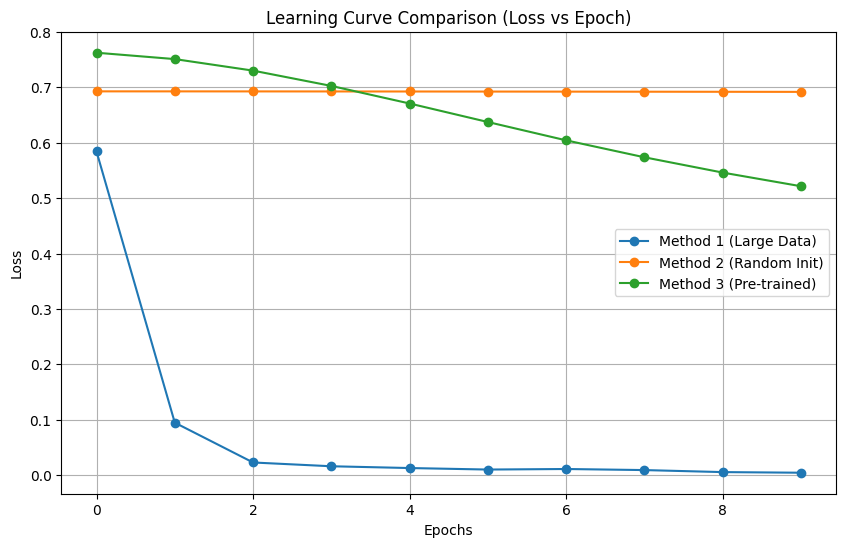


=== Final Performance Comparison ===
                           Method  Accuracy  Precision  Recall  F1 Score
0      M1: Train Scratch (Task A)      1.00     1.0000    1.00    1.0000
1        M2: Random Init (Task B)      0.50     0.2500    0.50    0.3333
2  M3: Transfer Learning (Task A)      0.67     0.8012    0.67    0.6297


In [12]:
# --- Plot Learning Curves ---
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history, label=name, marker='o')

plt.title("Learning Curve Comparison (Loss vs Epoch)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# --- Performance Table ---
df_results = pd.DataFrame(results)
# Formatting for cleaner output
pd.set_option('display.precision', 4)
print("\n=== Final Performance Comparison ===")
print(df_results)

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1 -> Pre-training then Fine-tuning works best. It outperforms random initialization because the model starts with robust feature extractors (detecting edges, curves) learned from the large dataset. It doesn't need to learn "how to see" from scratch, only "what to look for" in the new task.

2 -> This is adaptation and filtering. Even though the model has seen "2" and "3" before, the classification head (final layer) is brand new and random. Fine-tuning does two things:

Aligns the pre-learned features to the new binary output layer.

Suppresses features relevant to the other 8 classes (0, 1, 4-9) that are now noise.

3 -> Yes, due to universal low-level features.

Why: Early layers detect simple shapes (vertical lines, loops) present in both digits and letters.

How: Freeze the early layers (to keep the edge detectors) and retrain only the later layers. The later layers need to learn how to combine those edges into "A" or "B" instead of "1" or "8".

4 -> No, we used Transfer Learning.

Transfer Learning: Optimizes weights to be good at a specific source task (0-9 classification), hoping they transfer well.

Meta-Learning: Optimizes the initialization itself explicitly for adaptability. It trains the model so that a few steps of gradient descent on any new task will result in high accuracy (e.g., MAML).

# ALL THE BEST !